# 1D Heat equation; MLP

In [1]:
# initial plot
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import pandas as pd

We will store the temperature u, at a given x,t in a 2D tensor called U(t,x)

In [2]:
# setup time-space geometry
num_points = 51
x_start = 0
x_stop = 1
num_timesteps = 1000
t_start = 0
t_stop = 1 

# 2D array to hold U(x,t)
x = np.linspace(start=x_start, stop=x_stop, num=num_points)
t = np.linspace(start=t_start, stop=t_stop, num=num_timesteps)
U = np.zeros((t.shape[0],x.shape[0]))
print(U.shape)

#Thermal diffusivity
alpha = 1.22e-3

#Numerical stability constraints
dx = x[1] - x[0] 
dt = 0.5 * dx**2 / alpha
sigma = alpha * dt / dx**2

#Intital conditions at t=0
U[0][:] = np.sin(np.pi * x)

# plot factor
plot_factor = int(np.floor(num_timesteps / 5))

(1000, 51)


In [3]:
def delta_heat(u):
    sigma = alpha * dt / dx**2
    return (sigma * (u[2:] - 2*u[1:-1] + u[:-2]))

plotting at timestep 0
plotting at timestep 200
plotting at timestep 400
plotting at timestep 600
plotting at timestep 800


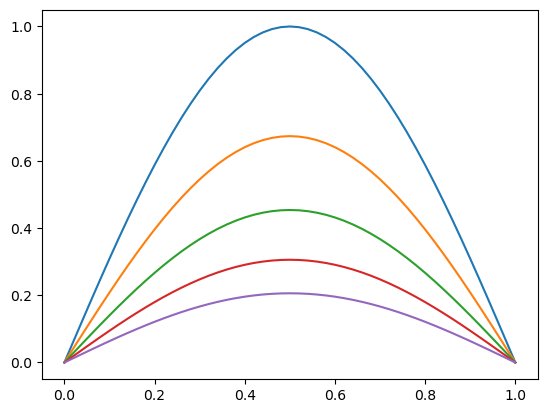

In [4]:
# evolve the heat over all timesteps
for tstep in range(len(t)):
    if tstep == 0:
        print(f"plotting at timestep 0")
        plt.plot(x,U[tstep][:])
        continue
    U[tstep][1:-1] = U[tstep-1][1:-1] + delta_heat(U[tstep-1][:])
    if tstep % plot_factor == 0:
        print(f"plotting at timestep {tstep}")
        plt.plot(x,U[tstep][:])

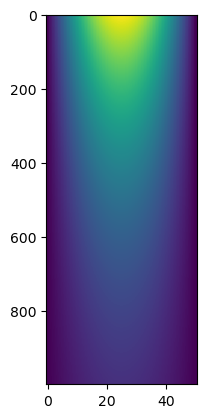

In [5]:
#Plot 2D heat diffusion using imshow
# - x axis is space
# - y axis is time
plt.imshow(U, aspect=0.125)

In [6]:
#Save numpy array to file to avoid having to recreate it every time
#Not a big deal here but will help when we extend to larger problem sizes
np.save("./1d-heat",U)

## Classic MLP Neural Network to learn the 1D-heat diffusion equation

The goal of the following section is to show the failure of MLP with no physics constraints

Prepare data for model tranining by extend the Dataset class to use our custom data \
Following this tutorial: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Use Dataset to store the samples and their corresponding labels
- DataLoader wraps an iterable around the Dataset to enable easy access to the samples

In [7]:
U_load = np.load("./1d-heat.npy")

In [10]:
features = np.ones((U_load.shape[0]*U_load.shape[1],2))
features[:,1] = np.tile(x,U_load.shape[0])
features[:,0] = np.repeat(t,U_load.shape[1])
print(features[0:5])
print(features[-5:])

[[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]
[[1.   0.92]
 [1.   0.94]
 [1.   0.96]
 [1.   0.98]
 [1.   1.  ]]


In [27]:
labels = np.ones((U_load.shape[0]*U_load.shape[1],1))
labels = U_load.ravel()
labels[0:5]

array([0.        , 0.06279052, 0.12533323, 0.18738131, 0.24868989])

In [39]:
labels = labels.astype(np.float32)
features = features.astype(np.float32)

At this point we have got our data from a saved file into two tensors.
A 1-D tensor of output temperatures and a 2D tensor of space (x) and time (t) input values.

Now we need to seperate training data from testing data. \
What else needs to happen....scale it? Cross-validation? How do these techniques fit into DNN?
Possivly use normalize as a transform that gets pased to the dataset class

In this next section I need to take the output from above and get it into a Dataset/DataLoader format to be used by the model

In [40]:
class HeatDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = self.features[idx]
        y = self.labels[idx]

        if self.transform:
            x = self.transform(x)
            y = self.transform(y)

        return x, y

#At the moment we can ignore test and train just to get model setup and confirmed 
#producing output
# train_dataloader = HeatDataset(training_data, batch_size=64, shuffle=True)
# test_dataloader = HeatDataset(test_data, batch_size=64, shuffle=True)

In [41]:
#This will use GPU if available, 
#then look for Apple Silicon Metal accelerator
#then finally it'll use the CPU.
#device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"#
#print(f"Using {device} device")

In [49]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)
    
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss      
        X = X.to(device)
        y = y.to(device)
        
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [46]:
model = NeuralNetwork()

dataset = HeatDataset(features, labels)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(data_loader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.042623  [    1/51000]
loss: 0.028396  [  101/51000]
loss: 0.014117  [  201/51000]
loss: 0.019329  [  301/51000]
loss: 0.035399  [  401/51000]
loss: 0.008802  [  501/51000]
loss: 0.005741  [  601/51000]
loss: 0.000118  [  701/51000]
loss: 0.004925  [  801/51000]
loss: 0.053679  [  901/51000]
loss: 0.044092  [ 1001/51000]
loss: 0.001064  [ 1101/51000]
loss: 0.082240  [ 1201/51000]
loss: 0.009834  [ 1301/51000]
loss: 0.019417  [ 1401/51000]
loss: 0.013210  [ 1501/51000]
loss: 0.059518  [ 1601/51000]
loss: 0.046560  [ 1701/51000]
loss: 0.028664  [ 1801/51000]
loss: 0.001579  [ 1901/51000]
loss: 0.000500  [ 2001/51000]
loss: 0.071006  [ 2101/51000]
loss: 0.000529  [ 2201/51000]
loss: 0.082307  [ 2301/51000]
loss: 0.000008  [ 2401/51000]
loss: 0.000850  [ 2501/51000]
loss: 0.065900  [ 2601/51000]
loss: 0.008086  [ 2701/51000]
loss: 0.079670  [ 2801/51000]
loss: 0.031016  [ 2901/51000]
loss: 0.029785  [ 3001/51000]
loss: 0.055031  [ 3101/51000]


In [50]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"#
print(f"Using {device} device")

model = NeuralNetwork()

dataset = HeatDataset(features, labels)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(data_loader, model, loss_fn, optimizer, device)
print("Done!")

Using mps device
Epoch 1
-------------------------------


RuntimeError: Placeholder storage has not been allocated on MPS device!